In [1]:
!pip install photutils  # we'll use photutils to make synthetic images
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from photutils.datasets import make_model_image, make_model_params

from regularizepsf import simple_functional_psf, varied_functional_psf, ArrayPSFTransform, ArrayPSFBuilder
from regularizepsf.util import calculate_covering
from regularizepsf.visualize import visualize_patch_counts


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Example

We will walk through how to use the various parts of `regularizePSF`. We will generate fake data with an irregular PSF and test if we can determine the underlying PSF and correct it. 

To start, we will generate some fake point spread functions. 

In [2]:
# Define the parameters and directory of images to use
psf_size = 64  # size of the PSF model to use in pixels
initial_sigma = 3.1
img_size = 512

@simple_functional_psf
def baked_in_initial_psf(row,
                         col,
                         x0=psf_size / 2,
                         y0=psf_size / 2,
                         sigma_x=initial_sigma,
                         sigma_y=initial_sigma,
                         A=0.1):
    return A * np.exp(-(np.square(row - x0) / (2 * np.square(sigma_x)) + np.square(col - y0) / (2 * np.square(sigma_y))))


@simple_functional_psf
def target_psf(row,
                        col,
                        core_sigma_x=initial_sigma,
                        core_sigma_y=initial_sigma,
                        tail_angle=0,
                        tail_separation=0,
                        ):
    x0 = psf_size / 2
    y0 = psf_size / 2
    A = 0.1
    core = A * np.exp(
        -(np.square(row - x0) / (2 * np.square(core_sigma_x)) + np.square(col - y0) / (2 * np.square(core_sigma_y))))

    A_tail = 0.05
    sigma_x = tail_separation
    sigma_y = core_sigma_y + 0.25
    a = np.square(np.cos(tail_angle)) / (2 * np.square(sigma_x)) + np.square(np.sin(tail_angle)) / (
                2 * np.square(sigma_y))
    b = -np.sin(tail_angle) * np.cos(tail_angle) / (2 * np.square(sigma_x)) + (
                (np.sin(tail_angle) * np.cos(tail_angle)) / (2 * np.square(sigma_y)))
    c = np.square(np.sin(tail_angle)) / (2 * np.square(sigma_x)) + np.square(np.cos(tail_angle)) / (
                2 * np.square(sigma_y))
    tail_x0 = x0 - tail_separation * np.cos(tail_angle)
    tail_y0 = y0 + tail_separation * np.sin(tail_angle)
    tail = A_tail * np.exp(-(a * (row - tail_x0) ** 2 + 2 * b * (row - tail_x0) * (col - tail_y0) + c * (col - tail_y0) ** 2))
    return core + tail


@varied_functional_psf(target_psf)
def synthetic_psf(row, col):
    return {"tail_angle": -np.arctan2(row - img_size//2, col - img_size//2),
            "tail_separation": np.sqrt((row - img_size//2) ** 2 + (col - img_size//2) ** 2)/105 * 2 + 1E-3,
            "core_sigma_x": 2.5,
            "core_sigma_y": 2.5}

coords = calculate_covering((img_size, img_size), psf_size)
example = synthetic_psf.as_array_psf(coords, psf_size)

Our synthetic PSF is a variable PSF meaning that it looks different in different parts of the image. This will be clear when we apply it to an image. For now, let's look at one example of the synthetic PSF. We can see that it has a core and then a long tail. The orientation and length of the tail will vary across the image.

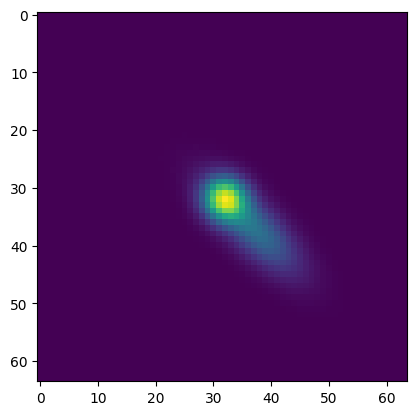

In [3]:
fig, ax = plt.subplots()
ax.imshow(example[(0, 0)])
plt.show()

Let's check out what the PSF looks like across an image. We'll start by simulating an image without coma. 

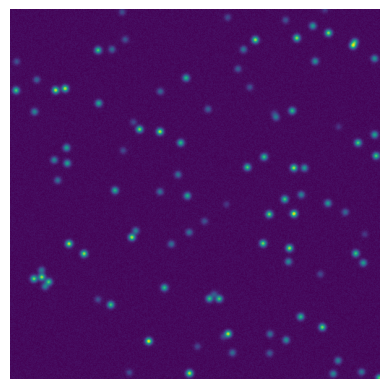

In [4]:
def simulate_perfect_image():
    model = Gaussian2D()
    shape = (img_size, img_size)
    n_sources = 100
    params = make_model_params(shape, n_sources, x_name='x_mean',
                               y_name='y_mean', min_separation=5,
                               amplitude=(100, 1000), x_stddev=(3, 3),
                               y_stddev=(3, 3), theta=(0, 0), seed=None)
    model_shape = (25, 25)
    image = make_model_image(shape, model, params, model_shape=model_shape,
                            x_name='x_mean', y_name='y_mean')
    image += np.random.uniform(0, 50, size=image.shape)
    image = image.astype(float)
    return image

example_image = simulate_perfect_image()

fig, ax = plt.subplots()
ax.imshow(example_image)
ax.set_axis_off()
plt.show()

The stars are uniform everywhere. It's time to apply our synthetic psf and see what happens! We'll define a PSF transform that converts this symmetric PSF to our new synthetic PSF. 

In [5]:
coords = calculate_covering((img_size, img_size), psf_size)
t = ArrayPSFTransform.construct(baked_in_initial_psf.as_array_psf(coords, psf_size), 
                                synthetic_psf.as_array_psf(coords, psf_size), 2.0, 0.3)

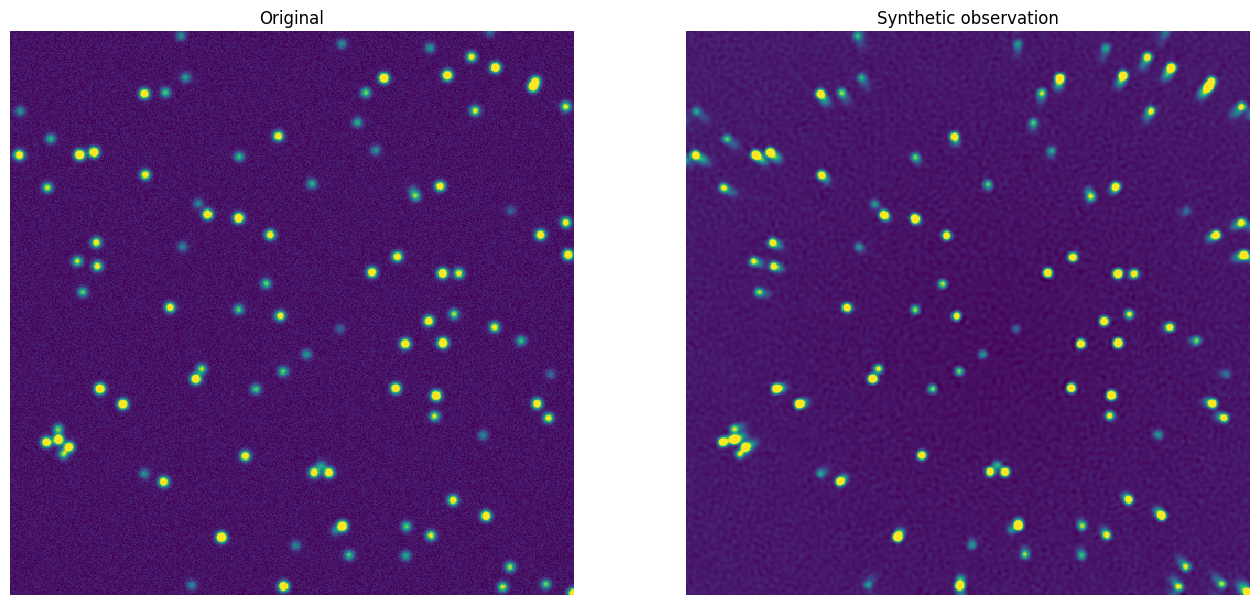

In [6]:
coma_image = t.apply(example_image)

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(example_image, interpolation='None', vmin=0, vmax=500)
axs[1].imshow(coma_image, interpolation='None', vmin=0, vmax=500)
for ax in axs:
    ax.set_axis_off()
axs[0].set_title("Original")
axs[1].set_title("Synthetic observation")
plt.show()

Look at how the stars have tails that are oriented differently in different parts of the image. That's our variable synthetic PSF at work!

Now, we'll generate 100 of these synthetic coma images. 

In [7]:
def simulate_coma_image(t):
    return t.apply(simulate_perfect_image())

images = np.array([simulate_coma_image(t) for _ in range(100)])

The real purpose of this package is to regularize or make the PSF homogeneous across the image. We have a handy utility to do just that. We'll extract the underlying PSF from the 100 images we just generated. 

In [8]:
b = ArrayPSFBuilder(psf_size)
model, counts = b.build(images)

The `ArrayPSFBuilder` provides both our model (we'll look at it in just a second) and a diagnostic of how many stars were used in each part of the image to build the model.

<Axes: xlabel='Patch number', ylabel='Patch number'>

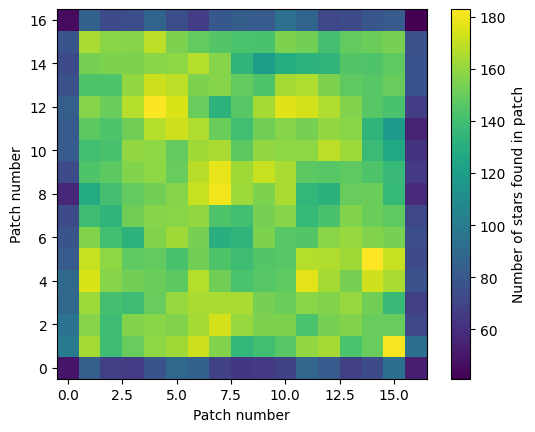

In [9]:
visualize_patch_counts(counts)

Most regions of the image had at least 140 stars used to build the model. That should be plenty! Let's inspect the model.

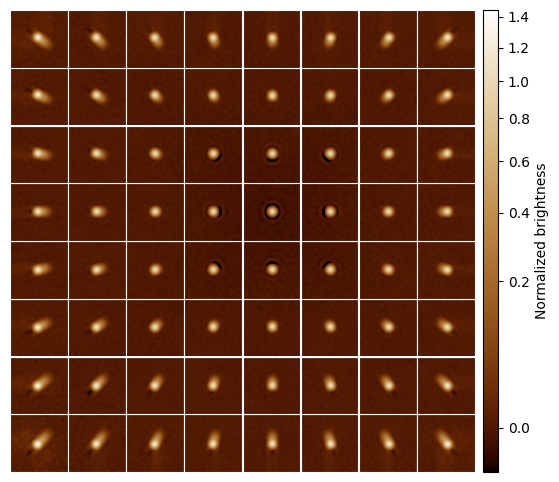

In [10]:
model.visualize_psfs(all_patches=False)

Yep! It varies kind of like how we expected. It's time now to use the model to undo the coma in an image. We'll define a uniform PSF as the output of our new transform and then apply it to each image. 

In [11]:
@simple_functional_psf
def uniform_psf(row,
             col,
             x0=psf_size / 2,
             y0=psf_size / 2,
             sigma_x=3.0,
             sigma_y=3.0,
             A=1.0):
    return A * np.exp(-(np.square(row - x0) / (2 * np.square(sigma_x)) + np.square(col - y0) / (2 * np.square(sigma_y))))

correcter = ArrayPSFTransform.construct(model, uniform_psf.as_array_psf(coords, psf_size), 2.0, 0.1)
corrected_images = np.array([correcter.apply(image) for image in images])

If we inspect an image, we'll see the coma is indeed reversed. This will work on any image observed using the telescope with this coma. If our telescope alignment changes, we can always build a new PSF model.

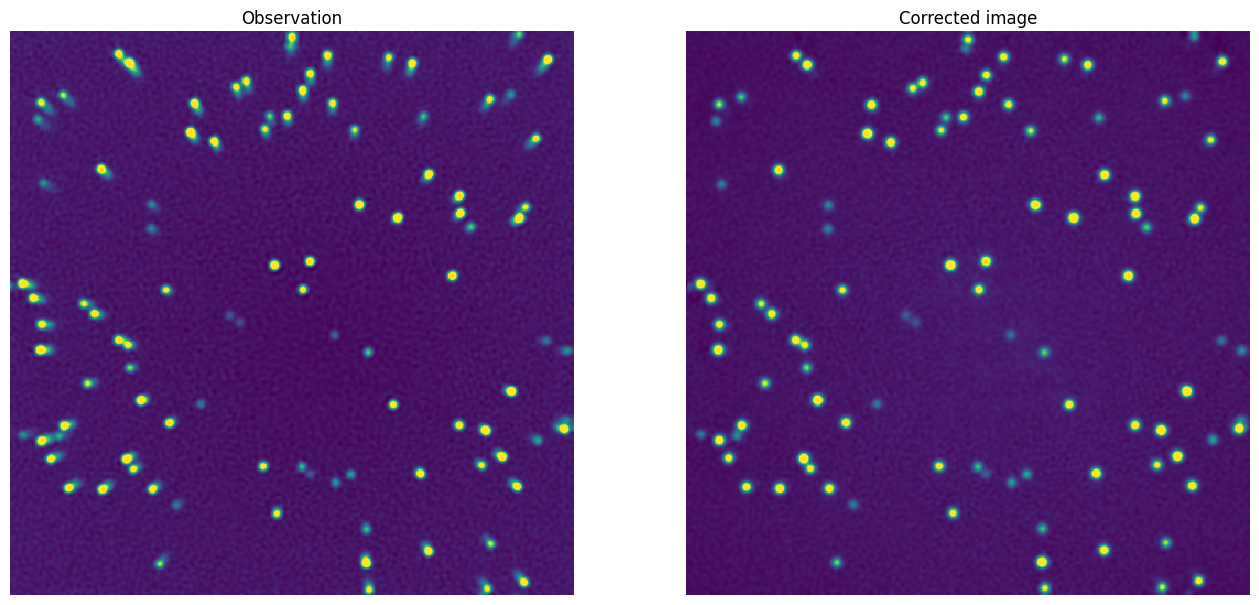

In [12]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(images[0], interpolation='None', vmin=0, vmax=500)
axs[1].imshow(corrected_images[0], interpolation='None', vmin=0, vmax=500)
for ax in axs:
    ax.set_axis_off()
axs[0].set_title("Observation")
axs[1].set_title("Corrected image")
plt.show()

If you're not convinced that the PSF is really corrected, we can build a new PSF model from our corrected images to see if there are any residuals. 

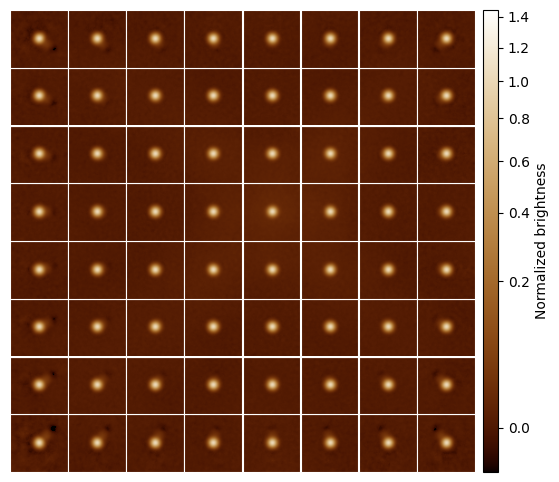

In [13]:
b = ArrayPSFBuilder(psf_size)
model, counts = b.build(corrected_images, average_method='median')
model.visualize_psfs(all_patches=False)

It looks pretty uniform! Our model worked! Let's save it for later. We can use either h5 or FITS. 

In [15]:
model.save(Path("model.fits"))
correcter.save(Path("corrector.fits"))

In [16]:
model.save(Path("model.h5"))
correcter.save(Path("corrector.h5"))